# Differential Analysis

![](./images/Module2/DE_pipeline.jpg)

The next step in the pathway analysis workflow is differential analysis (DE analysis). 
DE analysis is a fundamental method in genomics and bioinformatics that aims to identify genes or genomic elements exhibiting significant changes in expression levels between different experimental conditions. This analytical approach is crucial for understanding how gene expression patterns vary in response to different biological contexts, such as comparing healthy and diseased tissues or assessing the impact of various experimental treatments. The process typically includes data preprocessing, statistical analysis, multiple testing correction to control false discovery rates, and visualization techniques such as MA plots or volcano plots. 
This learning submodule demonstrates a computational workflow for the detection of DE genes using 2 example datasets of Microarray and RNA-Seq.

## Learning Objectives
1. Perform differential expression (DE) analysis using `limma`, `t-test`, `edgeR` and `DEseq` R packages.
2. Filter and export the results table.
3. Visualization of differential expression results.

### Table of Contents

1. [Differential Analysis](#de-analysis)
   -  1.1. [Differential Analysis using limma](#de-limma)
   -  1.2. [Differential Analysis using t-test](#de-ttest)
   -  1.3. [Differential Analysis using edgeR](#de-edger)
   -  1.4. [Differential Analysis using DESeq2](#de-deseq2)
2. [Differential Analysis Result Visualization](#visual-main)
   -  2.1. [MA plot](#visual-ma)
   -  2.2. [Volcano plot](#visual-vol)
3. [Gene-level Consensus Analysis](#visual-cc)
   -  3.1. [Venn diagram](#visual-venn)
   -  3.2. [Heatmap plot](#visual-heat)


<!-- ## Necessary Files
In this submodule, users will have to provide the following inputs: 
- (1) Gene expression/count matrix in which, rows are genes and columns are samples. We recommend using gene ID as gene SYMBOL. If users use other different gene ID types, please refer to our [previous submodule](./Module01-Data_Preparation.ipynb) and the [Data downloading and gene mapping](#gene-mapping) subsection for the instructions of gene mapping.
- (2) A table of sample information that has at least two columns: sample ID that matched the columns of the first input, and sample condition (e.g, control or disease) -->

<!-- If users use the data prepared in the previous submodule, they only need to use the code available in the previous module to download the data from Google Cloud Bucket and load it for the analyses. -->



In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-1.html" width=100% height=250></iframe>')

<!-- headings -->
<a id="gene-mapping"></a>
#### Data loading 

In previous submodule, we saved expression data/count matrices and the sample's group information. We will use the following commands to download the data from Google Cloud Bucket and load it.

In [2]:
# Create the data folder if not exists
dir.create("./data", showWarnings = FALSE)
# Download data from Google Cloud Bucket to the data folder
system("gsutil cp gs://ccpa_bucket/GSE5281.rds ./data")
system("gsutil cp gs://ccpa_bucket/GSE153873.rds ./data")
# Check the downloaded file in the data folder
list.files("./data")

[1] "export"                       "genes_GSE5281.csv"           
[3] "GPL570.soft.gz"               "GSE153873"                   
[5] "GSE153873.rds"                "GSE5281_series_matrix.txt.gz"
[7] "GSE5281.rds"                  "samples_GSE5281.csv"

In [3]:
# Load previously saved data
GSE5281Data <- readRDS("./data/GSE5281.rds")
# Get the expression data, sample informations and the gene id mapping table from the loaded data
gse5281_expr <- GSE5281Data$expression_data
gse5281_samples <- GSE5281Data$samples
# Get the mapping table for the gene ID mapping from PROBEID to SYMBOL
gse5281_genes <- GSE5281Data$genes

In [4]:
# Load previously saved data
GSE153873Data <- readRDS("./data/GSE153873.rds")
# Get the expression data, sample informations from the loaded data
gse153873_count <- GSE153873Data$expression_data
gse153873_samples <- GSE153873Data$samples

In [5]:
# Show some first rows of the Microarray expression data
head(gse5281_expr)
# Show some first rows of the RNA-Seq count matrix
head(gse153873_count)

,GSM119615,GSM119616,GSM119617,GSM119618,GSM119619,GSM119620,GSM119621,GSM119622,GSM119623,GSM119624,⋯,GSM238945,GSM238946,GSM238947,GSM238948,GSM238949,GSM238951,GSM238952,GSM238953,GSM238955,GSM238963
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDR1,9.440814,9.658471,10.751230,10.704818,11.124313,9.953529,10.448967,10.004300,9.527028,9.876236,⋯,9.942711,9.742474,11.019056,10.437638,10.442881,9.822437,10.366421,9.615128,10.601734,11.474948
RFC2,3.426978,4.325694,3.813565,3.968298,7.125949,3.033289,3.481672,5.131628,3.142327,5.365809,⋯,6.305425,5.872432,2.572259,3.592708,6.307571,5.688564,3.884119,5.842707,2.996099,5.088086
HSPA6,3.842662,4.264332,6.620960,6.632238,6.747769,6.639674,7.369176,5.563956,5.172644,6.206817,⋯,5.202476,6.752722,6.469541,5.340021,6.890082,4.434188,5.018104,5.399913,5.374466,4.331390
PAX8,7.443710,8.181477,9.071952,8.958108,8.903476,8.476106,8.872114,8.207421,7.817138,8.225375,⋯,6.852336,7.455557,7.505613,7.906416,7.800078,7.270819,8.041752,7.108190,8.159362,8.662045
GUCA1A,5.744617,6.799294,6.644170,4.194306,9.298787,6.731381,7.162584,6.954384,7.526671,7.506321,⋯,4.310260,6.340105,6.131104,2.770341,5.516825,3.639811,4.972412,5.383061,2.417264,5.435182
UBA7,6.103364,6.611478,6.272061,7.576066,8.116222,7.034395,7.049994,6.790131,6.004440,6.308591,⋯,6.774062,5.464315,6.748045,7.206096,7.475142,5.111186,7.647055,5.153291,7.157418,8.390668


,20-1T-AD,13-11T-Old,15-13T-Old,16-14T-Old,3-17T-Young,5-18T-Young,7-19T-Young,21-1A-AD,23-2A-AD,26-3A-AD,⋯,6-14A-Young,8-15A-Young,24-3T-AD,9-16A-Young,25-5T-AD,29-6T-AD,31-7T-AD,28-8T-AD,30-9T-AD,11-10T-Old
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SGIP1,1405,1405,1169,2408,859,1164,1402,1441,1003,1265,⋯,2953,1541,795,1614,833,1284,919,1004,1593,1174
NECAP2,295,460,334,347,617,585,372,343,374,315,⋯,220,424,426,387,552,328,353,474,344,350
AZIN2,356,306,385,507,787,751,577,238,209,241,⋯,396,394,179,424,567,292,301,319,348,575
AGBL4,191,200,173,323,36,89,184,229,129,154,⋯,431,38,46,231,45,123,155,108,247,156
CLIC4,876,1443,639,792,4806,5968,1392,1117,1247,929,⋯,729,8812,936,689,2534,856,646,1406,1255,665
SLC45A1,291,329,298,636,139,204,278,193,152,178,⋯,506,221,156,409,138,222,251,178,272,350


To perform differential expression analysis, samples need to be grouped based on different conditions. In this case, since we are using the `GSE5281` and `GSA153873` datasets, the samples should be divided into two groups: "c" ("normal/condition") and "d" ("alzheimer/disease"). We already have this from the sample information saved in the previous submodule. The following codes can be used to extract the necessary data for the analyses.

In [6]:
# Extract necessary data for Gene Differential Analysis of the GSE5281 dataset
gse5281_anno <- data.frame(
    sample = colnames(gse5281_expr),
    group = gse5281_samples$condition,
    row.names = colnames(gse5281_expr),
    stringAsFactors = FALSE
)

# Extract necessary data for Gene Differential Analysis of the GSA153873 dataset
gse153873_anno <- data.frame(
    sample = colnames(gse153873_count),
    group = gse153873_samples$condition,
    row.names = colnames(gse153873_count),
    stringAsFactors = FALSE
)

To see the number of *normal* and *alzheimer*, we can use the following command:

In [7]:
# show the number of normal (control) and alzheimer (disease) of the GSE5281 dataset
table(gse5281_anno$group)


 c  d 
74 87 

<!-- headings -->
<a id="de-analysis"></a>
## 1. Differential Analysis

<!-- headings -->
<a id="de-limma"></a>
### 1.1. Differential Analysis using limma
By far, the most popular package for performing differential expression is `limma`. This package provides a flexible framework for the analysis of gene expression data, with a focus on detecting differentially expressed genes between two or more conditions.
It offers a variety of statistical methods and models to handle different experimental designs, including single and multiple groups, paired samples, and time-series data. It also includes various normalization and quality control procedures to preprocess raw data and improve the accuracy and reproducibility of downstream analysis.


Traditional approaches for analyzing gene expression data normally treat the variances of each gene as independent and estimate them based on the limited number of samples available. However, this can lead to inaccurate estimates due to the small sample size and high variability of gene expression data.
To address this problem, in `limma`, the empirical Bayesian (EB) statistical methods are used to improve the estimation of gene-specific variances and fold changes in the analysis of gene expression data.
These methods leverage information from other genes within the same dataset to enhance the accuracy of estimating gene-specific variances. This is achieved by initially estimating the overall distribution of variances across all genes and subsequently utilizing this distribution to estimate the variances for individual genes.
By doing so, it can improve the detection of differentially expressed genes, particularly for genes with low expression levels or small sample sizes. The EB methods also provide more stable estimates of variances across multiple experiments, making it easier to compare results across different datasets.

In [8]:
# Install limma package
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        suppressWarnings(install.packages("BiocManager"))
    }
    suppressWarnings(BiocManager::install("limma", update = T))
    
})
# Import limma package
suppressPackageStartupMessages({
    library("limma")
})

To perform the `limma` analysis, we will utilize the `runLimma` function provided below. This function requires a normalized expression matrix, a design matrix, and a contrast matrix as inputs to execute the `limma` test using the `lmFit` and `eBayes` functions. Subsequently, the `topTable` function from the limma package will be employed to generate a table of the top-ranked genes based on the fitted model. By default, `topTable` organizes genes from the smallest to the largest adjusted p-value, including associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-values for each gene. The desired number of top genes to be displayed can be specified, where `number=Inf` includes all genes. Following the analysis, the `runLimma` function will return a dataframe containing the results of the analysis.

In [9]:
#' @description This function performs differential expression analysis using limma
#'
#' @param normExprs A matrix or data frame containing gene expression values. Rows represent genes, and columns represent samples.
#' @param design A matrix or data frame specifying the experimental design for the linear model. Each column corresponds to a different experimental factor or covariate.
#' @param contrast A matrix or data frame defining the contrasts of interest for the differential expression analysis. Each row represents a contrast.
#' @return A list containing a limma-fitted model and an analysis result dataframe.

runLimma <- function(normExprs, design, contrast) {
    # if (max(normExprs) > 100) normExprs <- log2(normExprs + 1)
    
    # Fit a linear model
    fit <- lmFit(object = normExprs, design = design) 
    # Specify contrasts for differential expression
    fit <- contrasts.fit(fit = fit, contrasts = contrast) 
    # Empirical Bayes moderation of standard errors
    fit <- eBayes(fit)
    
    # Extract results and additional information
    DERes <- topTable(fit, coef = 1, number = nrow(normExprs), confint=TRUE)
    
    DERes$SYMBOL <- rownames(DERes)
    DERes$p.value <- DERes$P.Value
    DERes$statistic <- DERes$t
    DERes$avgExpr <- DERes$AveExpr
    DERes$pFDR <- DERes$adj.P.Val
    
    # Return a dataframe containing limma results
    limma_res = DERes[, c("SYMBOL", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
   
}

#### Microarray dataset

To use the `runLimma` function, we need to set up the design and contrast matrices. We can achieve this by separating our dataset's samples into the groups of interest. We will use the `model.matrix` function from `limma` package for this purpose. This function generates a design matrix with 0s and 1s, where each row corresponds to a sample, and each column represents a sample group. If there's a 1 in a cell, it indicates that the sample belongs to that specific group. For the GSE5281 dataset, we can create the groups, design and contrasts matrices as follows:

In [10]:
# Get the group information and convert it to factor
gse5281_anno$group <- factor(gse5281_anno$group)

# Create design matrix
design <- model.matrix(object = ~0 + group, gse5281_anno)
design

,groupc,groupd
GSM119615,1,0
GSM119616,1,0
GSM119617,1,0
GSM119618,1,0
GSM119619,1,0
GSM119620,1,0
GSM119621,1,0
GSM119622,1,0
GSM119623,1,0
GSM119624,1,0


To create the contrast matrix, we need to specify the comparison we're interested in. In this analysis, with two groups, we only have one contrast of interest. Multiple contrasts can be defined in the `makeContrasts` function.
To use the `makeContrasts` function, we need to pass the following arguments:

- `contrasts`: A character string specifying contrasts.
- `levels`: A character vector or factor giving the names of the parameters of which contrasts are desired, or a design matrix or other object with the parameter names as column names.

The `makeContrasts` function returns a matrix with columns corresponding to contrasts.


In [11]:
# Set up contrasts of interest and recalculate model coefficients
cont.matrix <- limma::makeContrasts("groupd-groupc", levels = design)
cont.matrix

,groupd-groupc
groupc,-1
groupd,1


Now we can use the `runLimma` function to perform limma DE analysis on GSE5281 dataset.

In [12]:
# Run limma analysis using runLimma function
gse5281LimmaRes <- runLimma(normExprs = gse5281_expr, design = design, contrast = cont.matrix)
# Print some top genes of limma result
head(gse5281LimmaRes[order(gse5281LimmaRes$pFDR), ])

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TUBB,TUBB,1.432179e-22,3.177289e-18,-11.36377,-1.631276,9.123189
PSMB3,PSMB3,2.388997e-21,1.829653e-17,-10.92825,-1.408793,8.736749
TUBB4B,TUBB4B,2.474176e-21,1.829653e-17,-10.92281,-1.726316,10.297977
SLC35E1,SLC35E1,7.401763e-21,4.105203e-17,10.75253,1.627450,11.470567
ATP5F1C,ATP5F1C,9.950015e-21,4.414822e-17,-10.70648,-1.881757,10.012823
ATP5F1B,ATP5F1B,2.802296e-20,1.036149e-16,-10.54504,-1.616196,10.576243


#### RNA-Seq dataset

For the GSE153873 dataset, we can do the similar steps as we did with the GSA5281 dataset.

In [13]:
# Normalize the count matrix of the RNA-seq data for limma 
gse153873_count_normalized <- log2(gse153873_count + 1)
# Get the group information and convert it to factor
gse153873_anno$group <- factor(gse153873_anno$group)
# Create design matrix
design <- model.matrix(object = ~0 + group, gse153873_anno)
# Set up contrasts of interest and recalculate model coefficients
cont.matrix <- limma::makeContrasts("groupd-groupc", levels = design)
# Run limma analysis using runLimma function
gse153873LimmaRes <- suppressWarnings(runLimma(normExprs = gse153873_count_normalized, design = design, contrast = cont.matrix))
# Print some top genes of limma result
head(gse153873LimmaRes[order(gse153873LimmaRes$pFDR), ])

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC101926975,LOC101926975,3.656235e-09,9.921193e-05,-8.344000,-1.8227116,3.023096
ZNF596,ZNF596,1.039453e-07,9.436325e-04,-7.031987,-0.9139531,6.144073
MED29,MED29,1.043264e-07,9.436325e-04,-7.030596,-0.7998715,10.203245
RABGEF1,RABGEF1,2.890031e-07,1.751271e-03,-6.646324,-0.3878036,9.562289
DPH2,DPH2,3.573454e-07,1.751271e-03,-6.566992,-0.7689566,7.747132
ALB,ALB,3.872351e-07,1.751271e-03,-6.537030,-2.0374944,3.125139


Now, we can save the DE analysis result to use in the later submodules.

In [14]:
# Save the data to the local disk using either rds or csv format
# Save files in .rds fomat
saveRDS(gse5281LimmaRes, file = "./data/gse5281LimmaRes.rds")
saveRDS(gse153873LimmaRes, file = "./data/gse153873LimmaRes.rds")

# Save files in .csv format
write.csv(gse5281LimmaRes, file = "./data/gse5281LimmaRes.csv")
write.csv(gse153873LimmaRes, file = "./data/gse153873LimmaRes.csv")

# Add the limma result to the data list to save them all together in an rds file, we will do the same to other methods
GSE5281Data$limma_results <- gse5281LimmaRes
GSE153873Data$limma_results <- gse153873LimmaRes

# Save files in Google Cloud Bucket

# Replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/limma_results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/gse5281LimmaRes.rds gs://ccpa_bucket", intern = TRUE)
system("gsutil cp ./data/gse153873LimmaRes.rds gs://ccpa_bucket", intern = TRUE)


character(0)

character(0)

<!-- headings -->
<a id="de-ttest"></a>
### 1.2 Differential Analysis using t-test
In gene expression analysis, t-test serves as a widely used statistical method for detecting differentially expressed (DE) genes. The fundamental concept underlying a t-test is to assess the difference in means relative to the variability within each group. A more substantial difference in means, in comparison to the variability within each group, suggests a higher likelihood of the difference being statistically significant.

In the context of gene expression data, a t-test is typically applied to each gene separately. For each gene, the mean expression level in the treatment group is compared to the mean expression level in the control group. T-test produces a p-value that indicates the probability of observing the observed difference in means by chance.
In order to identify DE genes, a significance threshold (or "alpha value") is chosen. Any gene with a p-value below this threshold is considered to be differentially expressed. The threshold is typically set at 0.05, meaning that there is a 5% chance of falsely identifying a gene as DE. We can use `row_t_welch` available in the `matrixTests` package to perform t-test between the two groups for each gene. Below is the code to install the necessary packages:

In [15]:
# Install matrixTests package
suppressMessages({
    suppressWarnings(install.packages("matrixTests", quiet = T))
})

# Import matrixTests package
suppressPackageStartupMessages({library("matrixTests")})

To conduct t-Test differential expression (DE) analysis, we can utilize the `runTtest` function in the provided code. The required inputs include an expression matrix, group information, and the type of alternative hypothesis for the test. The function will yield a dataframe containing the statistical results of the analysis.

In [16]:
#' @description This function performs differential expression analysis using t-test 
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. Should have the same length as the number of columns in countMatrix.
#' @param alternative The type of alternative hypothesis for the t-test ("two.sided", "less", or "greater").
#' @return A dataframe containing the result of the analysis.

runTtest <- function(countMatrix, groups, alternative = "two.sided") {
    # if (max(countMatrix) > 100) countMatrix <- log2(countMatrix + 1)

    grUnique <- unique(groups)
    # Divide the countMatrix matrix into two separate matrices X and Y. X is the control group and Y is the disease group
    X <- countMatrix[, groups == grUnique[1]]
    Y <- countMatrix[, groups == grUnique[2]]

    # Perform Welch's t-test using row_t_welch function
    tTest_res <- suppressWarnings(row_t_welch(x = X, y = Y, alternative = alternative, conf.level = 0.95))
    
    # Extract results and additional information    
    tTest_res$SYMBOL <- rownames(tTest_res)
    tTest_res$p.value <- tTest_res$pvalue
    tTest_res$statistic <- tTest_res$statistic
    tTest_res$logFC <- log2(tTest_res$mean.y) - log2(tTest_res$mean.x)
    tTest_res$avgExpr <- rowMeans(countMatrix)
    
    # Adjust p-values for multiple testing using the false discovery rate (FDR)
    tTest_res$pFDR <- p.adjust(tTest_res$p.value, method = "fdr")
    
    # Return the results with only important columns
    tTest_res[, c("SYMBOL", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}



#### Microarray dataset

In [17]:
# Run t-test analysis using runTtest function with GSE5281 dataset
gse5281TtestRes <- runTtest(countMatrix = gse5281_expr, groups = as.factor(gse5281_anno$group))
# Show some first rows of the result tables
head(gse5281TtestRes)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDR1,DDR1,2.726390e-13,3.688108e-11,-8.2065100,0.15338875,9.738859
RFC2,RFC2,7.639613e-03,2.832300e-02,2.7045519,-0.16549110,4.826661
HSPA6,HSPA6,5.053565e-01,6.822451e-01,0.6676391,-0.03513683,5.174343
PAX8,PAX8,1.032228e-01,2.279058e-01,-1.6399110,0.04013541,7.693367
GUCA1A,GUCA1A,4.049680e-02,1.101945e-01,2.0672140,-0.11901233,5.350550
UBA7,UBA7,5.969303e-04,3.271467e-03,-3.5148444,0.11727136,6.392134


#### RNA-Seq dataset

In [18]:
# Run t-test analysis using runTtest function with GSE153873 dataset
gse153873TtestRes <- runTtest(countMatrix = gse153873_count_normalized, groups = as.factor(gse153873_anno$group))
head(gse153873TtestRes)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SGIP1,SGIP1,0.0012270882,0.02371747,-3.6010219,0.08215025,10.496064
NECAP2,NECAP2,0.6234944628,0.79397072,0.4963944,-0.01105260,8.536523
AZIN2,AZIN2,0.0034020925,0.03893733,-3.2730126,0.09684578,8.539012
AGBL4,AGBL4,0.0660431729,0.22281177,-1.9150867,0.12275431,7.322219
CLIC4,CLIC4,0.3607282878,0.58679331,-0.9294218,0.04476076,10.450300
SLC45A1,SLC45A1,0.0003813355,0.01386466,-4.0371559,0.12722385,8.026798


In [19]:
# Save the data to the local disk using either rds or csv format
# Save files in .rds fomat
saveRDS(gse5281TtestRes, file = "./data/gse5281TtestRes.rds")
saveRDS(gse153873TtestRes, file = "./data/gse153873TtestRes.rds")

# Save files in .csv fomat
write.csv(gse5281TtestRes, file = "./data/gse5281TtestRes.csv")
write.csv(gse153873TtestRes, file = "./data/gse153873TtestRes.csv")

# Add the t-test result to the data list to save them all together in an rds file
GSE5281Data$tTest_results <- gse5281TtestRes
GSE153873Data$tTest_results <- gse153873TtestRes

# Save files in Google Cloud Bucket
# Replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/limma_results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/gse5281TtestRes.rds gs://ccpa_bucket", intern = TRUE)
system("gsutil cp ./data/gse153873TtestRes.rds gs://ccpa_bucket", intern = TRUE)


character(0)

character(0)

<!-- headings -->
<a id="de-edger"></a>
### 1.3. Differential Analysis using edgeR

edgeR is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-seq) data. The package uses empirical Bayesian methods to account for biological variability and gene-specific sequencing depth, making it a robust and powerful tool for identifying DE genes.


The basic workflow for DE analysis using edgeR involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: edgeR applies a normalization method called trimmed mean of M-values (TMM) to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the mean and variance of the log ratios of gene expression levels between pairs of samples.


4. Dispersion estimation: edgeR uses a negative binomial model to account for biological variability in gene expression data. This model estimates the dispersion of counts within and between samples, which reflects the amount of biological variability in gene expression data.


5. Differential expression analysis: edgeR uses a statistical framework called generalized linear models (GLMs) to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, edgeR applies a multiple testing correction method called the false discovery rate (FDR). This method adjusts p-values to control the expected proportion of false positives among all significant tests.


Overall, edgeR is a powerful and widely used tool for DE analysis of RNA-seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It also provides several visualization tools to help users explore and interpret the results.

In [20]:
# Install edgeR package from Bioconductor
suppressMessages({ 
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("edgeR"))
})
# Import edgeR package
suppressPackageStartupMessages({library("edgeR")})


To conduct differential expression (DE) analysis using the edgeR method, we can use the `runEdgeR` function. Similar to `runTtest`, `runEdgeR` function requires an expression matrix (countMatrix) and a groups factor (groups) and it will return a dataframe with essential statistical results for the edgeR DE analysis.

In [21]:
#' @description This function performs differential expression analysis using edgeR 
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. Should have the same length as the number of columns in countMatrix.
#' @return A dataframe containing the result of the analysis.

runEdgeR <- function(countMatrix, groups) {
    
    # Creates a DGEList object from a table of counts (rows=features, columns=samples), 
    # group indicator for each column, library size (optional) and a table of feature annotation (optional).
    dge <- DGEList(counts = countMatrix, group = factor(groups))
    
    # Calculating the normalization factor
    dge <- calcNormFactors(object = dge)
    
    # Estimate dispersion
    dge <- suppressMessages(estimateDisp(y = dge))
    
    # Perform exact test
    et <- exactTest(object = dge)
    
    # Getting top DE genes
    top_degs <- topTags(object = et, n = "Inf")  
    
    # Extract results and additional information
    top_degs$table$SYMBOL <- rownames(top_degs$table)
    top_degs$table$p.value <- top_degs$table$PValue
    top_degs$table$pFDR <- top_degs$table$FDR
    top_degs$table$statistic <- top_degs$table$logFC
    top_degs$table$avgExpr <- top_degs$table$logCPM
    
    # Return the results with only important columns
    top_degs$table[, c("SYMBOL", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}

Using the `runEdgeR` function, we can now conduct the `edgeR` differential analysis with the provided code.

#### Microarray dataset

In [22]:
# Run differential analysis using runEdgeR function with GSE5281 dataset
gse5281EdgeRRes <- runEdgeR(countMatrix = gse5281_expr, groups = as.factor(gse5281_anno$group))
head(gse5281EdgeRRes)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SST,SST,7.080598e-10,1.570831e-05,-0.5171403,-0.5171403,6.147887
TMEM106A,TMEM106A,1.954961e-08,1.532170e-04,0.5808589,0.5808589,5.747591
MIR9-1HG,MIR9-1HG,3.084974e-08,1.532170e-04,0.4688537,0.4688537,6.185845
KCNE4,KCNE4,3.312364e-08,1.532170e-04,0.5520398,0.5520398,5.807757
HIF3A,HIF3A,3.854443e-08,1.532170e-04,0.5054603,0.5054603,5.976659
COL1A1,COL1A1,4.143799e-08,1.532170e-04,0.5985071,0.5985071,5.635229


#### RNA-Seq dataset

In [23]:
# Run differential analysis using runEdgeR function with GSE153873 dataset
gse153873EdgeRRes <- runEdgeR(countMatrix = gse153873_count, groups = as.factor(gse153873_anno$group))
head(gse153873EdgeRRes)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC101926975,LOC101926975,1.020689e-10,1.581608e-06,-1.992590,-1.992590,-0.3342804
GMNC,GMNC,1.534999e-10,1.581608e-06,2.284438,2.284438,-1.1354461
ADAMTS2,ADAMTS2,1.757713e-10,1.581608e-06,1.560794,1.560794,3.7462452
LOC100506136,LOC100506136,2.331465e-10,1.581608e-06,1.556556,1.556556,1.2503550
DNAH11,DNAH11,8.022113e-10,4.353601e-06,1.247874,1.247874,2.5744443
LOC100129316,LOC100129316,1.117520e-09,5.053985e-06,1.799734,1.799734,1.1501805


Now, we can save the differential analysis result to use in the later submodules.

In [24]:
# Save the data to the local disk using either rds or csv format
# Save files in .rds format
saveRDS(gse5281EdgeRRes, file = "./data/gse5281EdgeRRes.rds")
saveRDS(gse153873EdgeRRes, file = "./data/gse153873EdgeRRes.rds")

# Save files in .rds format
write.csv(gse5281EdgeRRes, file = "./data/gse5281EdgeRRes.csv")
write.csv(gse153873EdgeRRes, file = "./data/gse153873EdgeRRes.csv")

# Add the edgeR result to the data list to save them all together in an rds file
GSE5281Data$edgeR_results <- gse5281EdgeRRes
GSE153873Data$edgeR_results <- gse153873EdgeRRes

# Save files in Google Cloud Bucket
# Replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/limma_results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/gse5281EdgeRRes.rds gs://ccpa_bucket", intern = TRUE)
system("gsutil cp ./data/gse153873EdgeRRes.rds gs://ccpa_bucket", intern = TRUE)


character(0)

character(0)

Similar to the two previous DE analysis methods, we will also visualize the DE result of edgeR with MA plots and volcano plots.

In [25]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-3.html" width=100% height=250></iframe>')

<!-- headings -->
<a id="de-deseq2"></a>
### 1.4. Differential Analysis using DESeq2
DESeq2 is a popular R package for differential expression (DE) analysis of RNA sequencing (RNA-Seq) data. The package uses a negative binomial distribution to model the gene expression counts and applies shrinkage estimation to improve the accuracy of differential expression analysis.


The basic workflow for DE analysis using DESeq2 involves several steps:


1. Data pre-processing: Raw sequencing reads are first pre-processed to filter out low-quality reads and align them to a reference genome. This step typically includes quality control, read trimming, and alignment.


2. Count matrix generation: A count matrix is generated by counting the number of reads that map to each gene in each sample. This matrix represents the raw gene expression data and is used as input for DE analysis.


3. Normalization: DESeq2 applies a normalization method called size factors to adjust for differences in sequencing depth between samples. This method calculates scaling factors for each sample based on the total number of reads in each sample.


4. Dispersion estimation: DESeq2 estimates the dispersion of counts within and between samples using a negative binomial distribution. This model accounts for biological variability in gene expression data and can handle low counts and overdispersion.


5. Differential expression analysis: DESeq2 uses a statistical framework called the Wald test to test for differential expression between two or more groups. This method models the relationship between gene expression and experimental factors (e.g., treatment, time, condition) to identify genes that are significantly differentially expressed.


6. Multiple testing correction: To control for the high false positive rate associated with testing many genes simultaneously, DESeq2 applies a multiple testing correction method called the Benjamini-Hochberg (BH) procedure. This method adjusts p-values to control the expected proportion of false positives among all significant tests.


DESeq2 also includes several visualization tools, such as principal component analysis (PCA) and heatmaps, to help users explore and interpret the results.


Overall, DESeq2 is a powerful and widely used tool for DE analysis of RNA-Seq data, offering a flexible framework for the detection of DE genes that accounts for biological variability and gene-specific sequencing depth. It is particularly useful for analyzing low-count genes and handling complex experimental designs.

In [26]:
# Install and import the ggplot2 package
suppressWarnings({
    suppressMessages({
        install.packages("ggplot2")
        library(ggplot2)
    })
})

# Installing and loading the library
suppressMessages({ 
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("DESeq2", update = F))
    
})

# Import DESeq2 package
suppressPackageStartupMessages({library("DESeq2")})

In [27]:
#' @description This function performs differential expression analysis using DESeq2
#'
#' @param countMatrix A matrix of gene expression data where rows represent genes and columns represent samples.
#' @param groups A vector specifying the grouping of samples. It should have the same length as the number of columns in countMatrix.
#' @return A dataframe containing the result of the analysis.

runDESeq2 <- function(countMatrix, groups) {
    
    # Constructing a group table that contains information about group members for all patients.
    coldata <- data.frame(
        sample = colnames(countMatrix),
        condition = as.factor(groups),
        row.names = "sample" 
    )
    
    # Suppressing messages to avoid printing DESeq2 messages
    suppressMessages({
        # Create a DESeqDataSet object
        dds <- DESeqDataSetFromMatrix(countData = round(countMatrix), colData = coldata,
                                      design = ~condition)
        # Relevel the 'condition' factor
        dds$condition <- relevel(x = dds$condition, ref = "c")
        #  # Filter out low-count rows
        # dds <- dds[rowSums(counts(dds)) >= 10, ]
        # Run DESeq analysis
        dds <- suppressWarnings(DESeq(object = dds))
    })

    # Get names of results
    resultsNames(object = dds)
    
    # Get differential expression results
    res <- results(object = dds)
    
    # Drop na rows
    res <- res[complete.cases(res), ]

    # Order results by adjusted p-value
    res <- as.data.frame(res[order(res$padj), ])

    # Extract results and additional information
    res$SYMBOL <- rownames(res)
    res$p.value <- res$pvalue
    res$statistic <- res$stat
    res$logFC <- res$log2FoldChange
    res$avgExpr <- log2(res$baseMean + 1)
    res$pFDR <- p.adjust(res$p.value, method = "fdr")
    
    # Return the results with only important columns
    res[, c("SYMBOL", "p.value", "pFDR", "statistic", "logFC", "avgExpr")]
}


Now we can perform `DESeq2` analysis with the `runDESeq2` function. 

#### Microarray dataset

In [28]:
# Run DESeq2 analysis using runDESeq2 function with GSE5281 dataset
gse5281DESeq2Res <- runDESeq2(countMatrix = gse5281_expr, groups = as.factor(gse5281_anno$group))
# Show some first rows of the result 
head(gse5281DESeq2Res)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SST,SST,1.129155e-08,0.0001970714,-5.710091,-0.5242242,2.971887
MIR9-1HG,MIR9-1HG,7.674145e-08,0.0006696842,5.374627,0.4835129,3.021356
SIMC1P1,SIMC1P1,3.085662e-07,0.0017951350,5.118138,0.4015684,3.259756
TMEM106A,TMEM106A,4.542612e-07,0.0019820551,5.044688,0.5967721,2.513752
HIF3A,HIF3A,7.322126e-07,0.0025558614,4.952619,0.5130156,2.786496
KCNE4,KCNE4,1.657230e-06,0.0048206066,4.791277,0.5523038,2.593759


#### RNA-Seq dataset

In [29]:
# Run DESeq2 analysis using runDESeq2 function with GSE153873 dataset
gse153873DESeq2Res <- runDESeq2(countMatrix = gse153873_count, groups = as.factor(gse153873_anno$group))
# Show some first rows of the result 
head(gse153873DESeq2Res)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NPC1L1,NPC1L1,5.347564e-12,1.147213e-07,6.896031,3.6836254,4.766138
TRAF3IP2-AS1,TRAF3IP2-AS1,4.105603e-11,2.935917e-07,6.600216,0.6036339,8.443113
TRAPPC1,TRAPPC1,3.229438e-11,2.935917e-07,-6.635710,-0.6230562,8.629783
LOC100506136,LOC100506136,7.284017e-11,3.906600e-07,6.514690,1.5676504,5.027996
MED29,MED29,2.622441e-10,1.125185e-06,-6.319598,-0.6422595,10.243159
LOC101926975,LOC101926975,3.774822e-10,1.349688e-06,-6.263065,-2.0326924,3.333696


Now, we can save the DE analysis result to use in the later submodules.

In [30]:
# Save the data to the local disk using either rds or csv format
# Save in .rds format
saveRDS(gse5281DESeq2Res, file = "./data/gse5281DESeq2Res.rds")
saveRDS(gse153873DESeq2Res, file = "./data/gse153873DESeq2Res.rds")

# Save in .csv format
write.csv(gse5281DESeq2Res, file = "./data/gse5281DESeq2Res.csv")
write.csv(gse153873DESeq2Res, file = "./data/gse153873DESeq2Res.csv")

# Add the DESeq2 result to the data list to save them all together in an rds file
GSE5281Data$deseq2_results <- gse5281DESeq2Res
GSE153873Data$deseq2_results <- gse153873DESeq2Res

# Save files in Google Cloud Bucket
# Replace the <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/limma_results.rds gs://<BUCKET_NAME>", intern = TRUE)
system("gsutil cp ./data/gse5281EdgeRRes.rds gs://ccpa_bucket", intern = TRUE)
system("gsutil cp ./data/gse153873EdgeRRes.rds gs://ccpa_bucket", intern = TRUE)

character(0)

character(0)

In [31]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-4.html" width=100% height=250></iframe>')

After completing all the analysis methods, we can now save the results to a single RDS file for convenience in using them in submodules 4 and 5.

In [32]:
# Save all data to .rds files
saveRDS(GSE5281Data, file = "./data/GSE5281.rds")
saveRDS(GSE153873Data, file = "./data/GSE153873.rds")

In [33]:
# Save all data to Google Cloud Bucket
# Replace <BUCKET_NAME> with the name of your bucket that was previously made in submodule 1
# system("gsutil cp ./data/GSE5281.rds gs://<BUCKET_NAME>", intern = TRUE)

system("gsutil cp ./data/GSE5281.rds gs://ccpa_bucket", intern = TRUE)
system("gsutil cp ./data/GSE153873.rds gs://ccpa_bucket", intern = TRUE)

character(0)

character(0)

In [34]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2.html" width=100% height=250></iframe>')

 <!-- headings -->
 <a id="visual-main"></a>
## 2. Differential Analysis Result Visualization

Visualizing DE results is pivotal for unraveling complex patterns within genomic data. As the outcomes of DE analysis often encompass numerous genes exhibiting diverse expression changes, employing effective visualization methods becomes essential to distill this information into interpretable and insightful representations. These visualizations not only assist in pinpointing significant gene expression differences but also contribute to uncovering broader trends and relationships. In this instruction, we will explore two specific visualization tools: the MA plot and the volcano plot. The MA plot compare the average expression level with the log2 fold-change while the volcano plot to compare the log2 fold-change with -log10 p-value. Together, these visualizations could enhance our understanding of the analysis results.

 <!-- headings -->
 <a id="visual-ma"></a>
### 2.1. MA plot
To visually summarize results for all genes from the DE analysis methods, we can use MA plots, which displays the difference between the average expression level (x-axis) against the log2 fold-change (y-axis), with the differentially expressed genes highlighted. 
In a usual MA plot, most points gather around a line showing zero change. If any points move up or down, it means there's a problem in the data that needs to be corrected. 
To create an MA plot, we will use the `ggplot2` package and the `plotMA` function below.

In [35]:
#' @description This function visualizes differential expression results with an MA plot
#'
#' @param DEResult A dataframe containing differential expression results, typically generated by a DE analysis function.
#' @param pThreshold A numerical value specifying the threshold of p-values to filter DE genes (default: 0.05).
#' @param useFDR A boolean indicating whether to use adjusted p-values (False Discovery Rate - FDR) for significance (default: TRUE).
#' @param logFCThreshold A numerical value specifying the threshold for absolute log-fold change to consider genes as differentially expressed (default: 1).
#' @param labels A vector of gene labels for highlighting specific genes (default: NULL).
#' @param fitMethod A character string specifying the method for fitting the smooth curve in the MA plot ("loess" or "lowess", default: "loess").
#' @return A plot visualizing the differential expression results with an MA plot.

plotMA <- function(DEResult, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5, labels = NULL, fitMethod = "loess") {
    # Filter the DE genes for the plot
    plotDat <- data.frame(
        x = DEResult$avgExpr,
        y = DEResult$logFC,
        isSig = (
            if (useFDR) {
                DEResult$pFDR < pThreshold
            } else {
                DEResult$p.value < pThreshold
            }
        )
    )
    # assign color for each gene
    plotDat$color <- factor(plotDat$isSig * (abs(plotDat$y) > logFCThreshold) * sign(plotDat$y), levels = c(1, -1, 0))

    if (!is.null(labels)) {
        plotDat$label <- labels[DEResult$PROBEID]
    }
    # Create the scatter plot using ggplot
    pl <- ggplot(plotDat, aes(x = .data$x, y = .data$y, color = .data$color)) +
        geom_point() +
        theme_bw() +
        theme_minimal() +
        theme(
            axis.line.x = element_blank(),
            axis.line.y = element_blank(),
        ) +
        scale_color_manual(
            values = c(
                "1" = "#B80F0A",
                "-1" = "#004F98",
                "0" = "darkgray"
            ),
            labels = c(
                "1" = paste0("Upregulated (", sum(plotDat$color == 1, na.rm = TRUE), ")"),
                "-1" = paste0("Downregulated (", sum(plotDat$color == -1, na.rm = TRUE), ")"),
                "0" = paste0("Not significant (", sum(plotDat$color == 0, na.rm = TRUE), ")")
            ),
            guide = guide_legend(override.aes = list(size = 3), title = "Significance")
        ) +
        theme(
            legend.position = "bottom"
        ) +
        labs(
            x = "Average expression",
            y = "Log2 fold change"
        ) +
        geom_hline(yintercept = -logFCThreshold, linetype = "dashed") +
        geom_hline(yintercept = logFCThreshold, linetype = "dashed")

    if (!is.null(labels)) {
        labelDat <- filter(plotDat, !is.na(.data$label))

        pl <- pl + geom_label_repel(
            labelDat,
            mapping = aes(x = .data$x, y = .data$y, label = .data$label),
            size = 3,
            segment.size = 0.75,
            segment.color = "#888888",
            color = "black",
            box.padding = 1,
            force = 3,
            point.size = NA
        )
    }
    # Create the fit curve for the data
    if (!is.null(fitMethod)) {
        pl <- pl + geom_smooth(
            formula = y ~ x,
            method = fitMethod,
            se = FALSE,
            color = "#228b22"
        ) +
            geom_hline(yintercept = 0, color = "#888888")
    }
    # return the plot
    pl

}

To create MA plots for the limma analysis results of the GSE5281 and GSE153873 datasets, we will use the `plotMA` function as follows: 

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

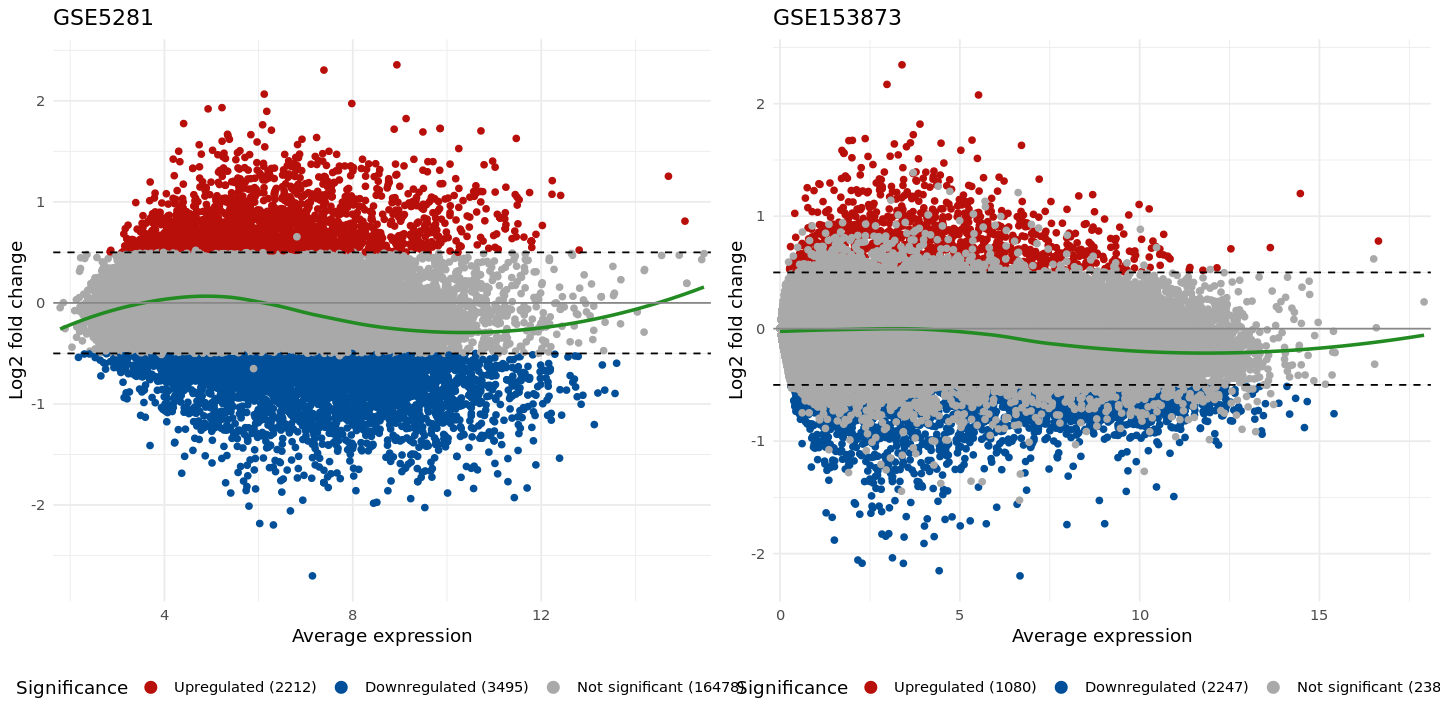

In [36]:
options(repr.plot.width = 6, repr.plot.height = 6)
# Create a MA plot for the limma result of the GSE5281 dataset
MA1 <- plotMA(DEResult = gse5281LimmaRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE5281")
# Create a MA plot for the limma result of the GSE153873 dataset
MA2 <- plotMA(DEResult = gse153873LimmaRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE153873")

options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedMA <- gridExtra::grid.arrange(
    MA1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    MA2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedMA

We construct the MA plot by the significance defined using a p-value cutoff that is set at 5% by default. For the comparison between expression levels in *“disease”* (alzheimer) and *“control”* (normal), 3495 genes are found to be down-regulated and 2212 genes are up-regulated in the limma result of GSE5281 dataset. 

For t-test results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

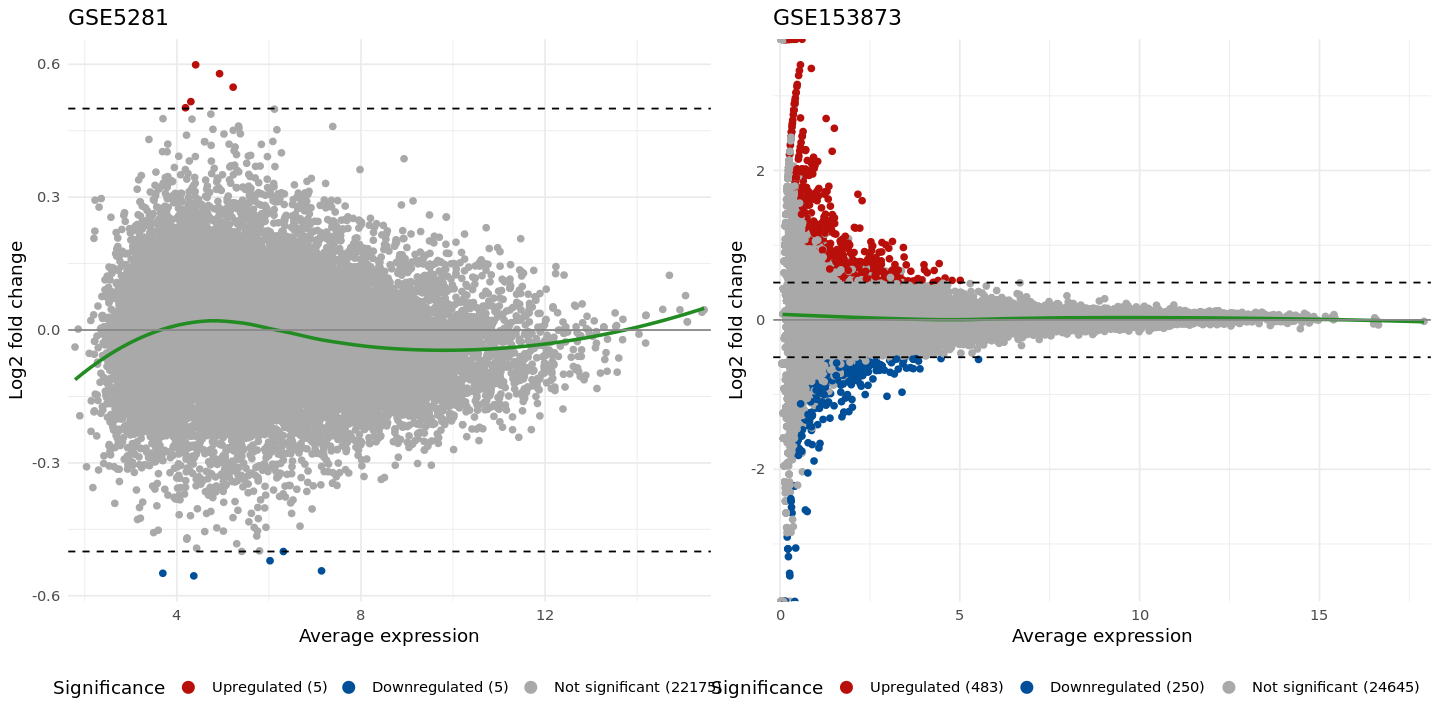

In [37]:
# Adjust size of the plot
options(repr.plot.width = 6, repr.plot.height = 6)
# Create a MA plot for the t-test result of the GSE5281 dataset
MAplt1 <- plotMA(DEResult = gse5281TtestRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5, labels = NULL) + ggtitle("GSE5281")
# Create a MA plot for the t-test result of the GSE153873 dataset
MAplt2 <- plotMA(DEResult = gse153873TtestRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5, labels = NULL) + ggtitle("GSE153873")

options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedMA <- suppressWarnings(gridExtra::grid.arrange(
    MAplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    MAplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
))
combinedMA

For edgeR results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

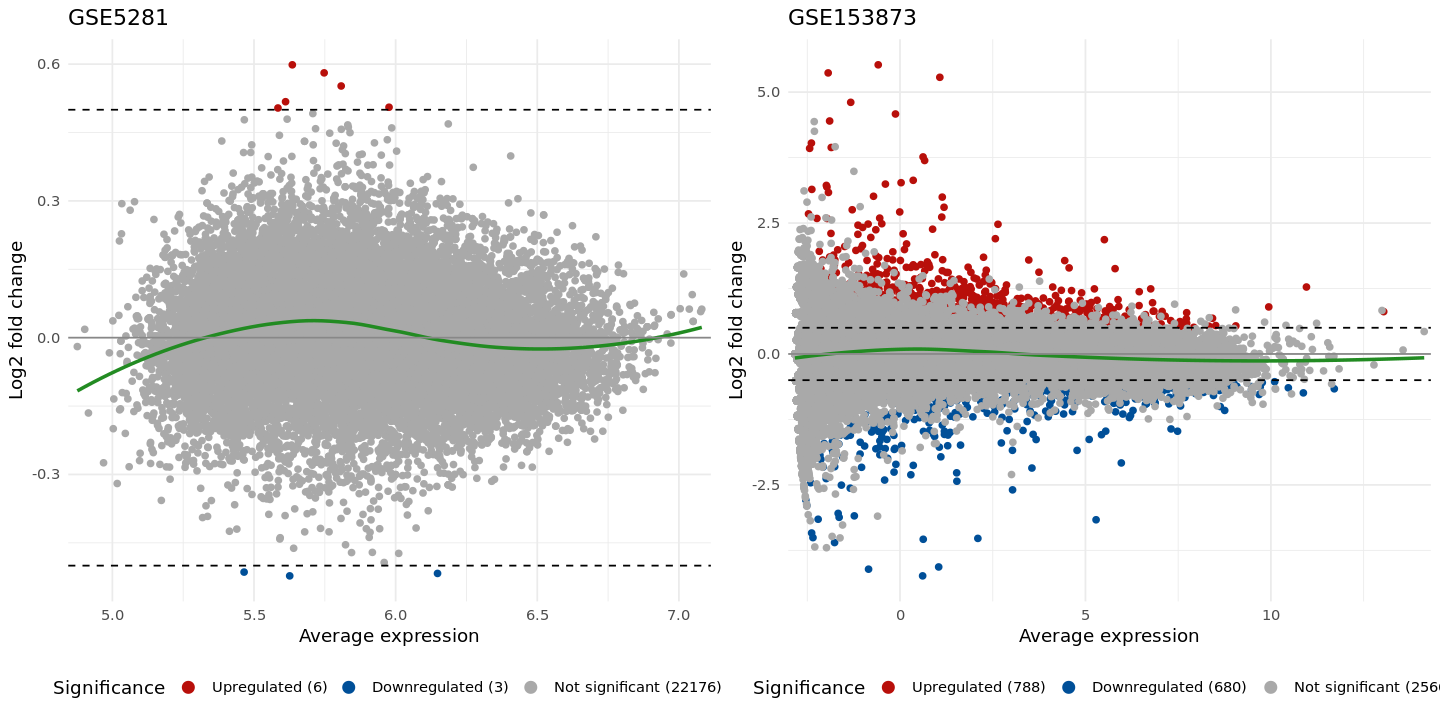

In [38]:
# Adjust size of the plot
options(repr.plot.width = 6, repr.plot.height = 6)
# Create a MA plot for the limma result of the GSE5281 dataset
MAplt1 <- plotMA(DEResult = gse5281EdgeRRes, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE5281")
# Create a MA plot for the limma result of the GSE153873 dataset
MAplt2 <- plotMA(DEResult = gse153873EdgeRRes, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedMA <- gridExtra::grid.arrange(
    MAplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    MAplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedMA

For DESeq2 results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

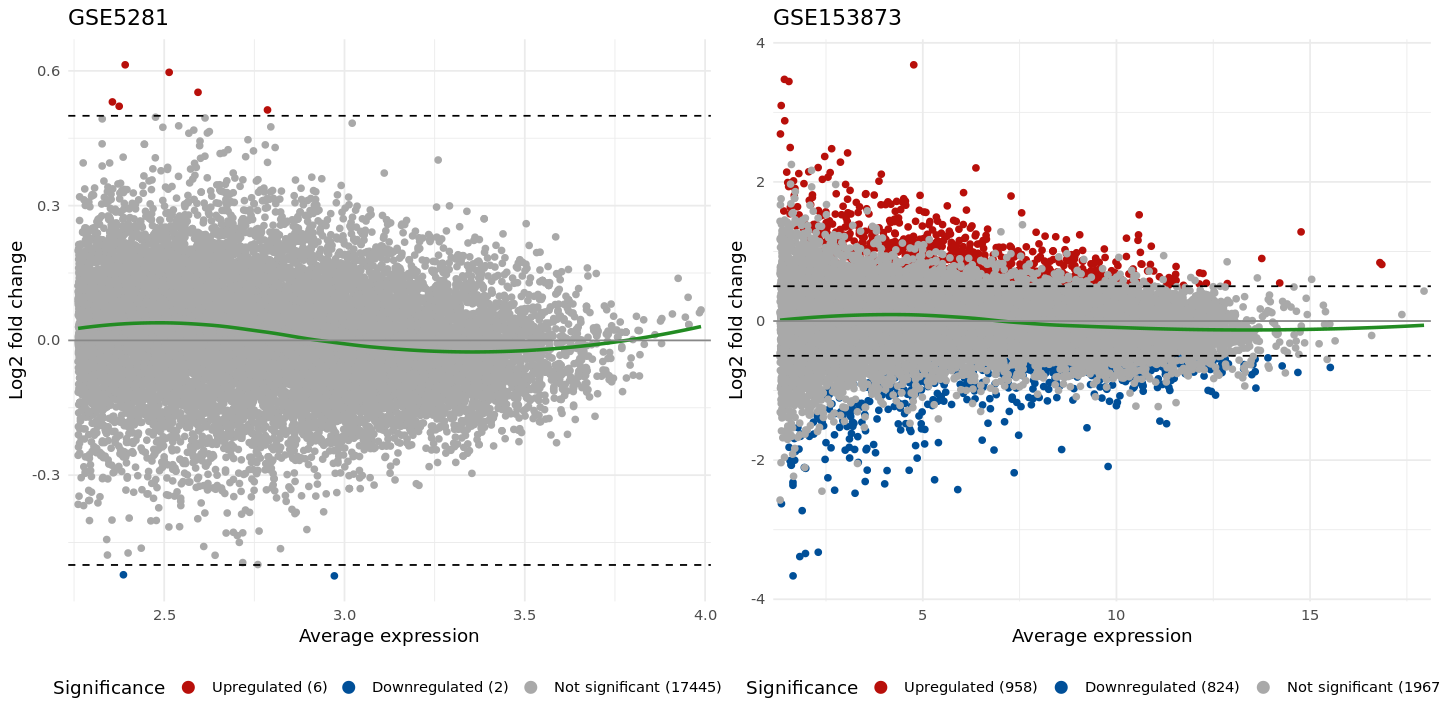

In [39]:
# Adjust size of the plot
options(repr.plot.width = 6, repr.plot.height = 6)
# Create a MA plot for the limma result of the GSE5281 dataset
MAplt1 <- plotMA(DEResult = gse5281DESeq2Res, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE5281")
# Create a MA plot for the limma result of the GSE153873 dataset
MAplt2 <- plotMA(DEResult = gse153873DESeq2Res, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedMA <- gridExtra::grid.arrange(
    MAplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    MAplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedMA

In [40]:
# Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule2-2.html" width=100% height=250></iframe>')

<!-- headings -->
 <a id="visual-vol"></a>
### 2.2. Volcano plot
The volcano plot is a special type of scatterplot that is commonly used for visualizing the results of DE analyses. In a volcano plot, the *x* axis shows the *log-fold* change and the *y* axis is some measure of statistical significance, which in this case is the -log10 of the p-value. A characteristic “volcano” shape should be seen. To create a volcano plot, we can use the function `plotVolcanoDE` below.

In [41]:
#' @description This function generates a volcano plot based on DE analysis results 
#'
#' @param DEResult A dataframe containing differential expression results, typically generated by a DE analysis function.
#' @param pThreshold A numerical value specifying the threshold for p-values to filter DE genes (default: 0.05).
#' @param useFDR A boolean indicating whether to use adjusted p-values (False Discovery Rate - FDR) for significance (default: TRUE).
#' @param logFCThreshold A numerical value specifying the threshold for absolute log-fold change to consider genes as differentially expressed (default: 1).
#' @return A filtered dataframe containing significant differential expression results.
#' @examples
#' filtered_result <- filter_differential_expression(de_result, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5)

plotVolcanoDE <- function(DEResult, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) {

    # Check if the required columns exist in the DEResult
    if (!"logFC" %in% colnames(DEResult)) {
        stop("The logFC column is not in the results data frame.")
    }

    if (useFDR && !("pFDR" %in% colnames(DEResult))) {
        stop("The pFDR column is not in the results data frame.")
    } else if (!("p.value" %in% colnames(DEResult))) {
        stop("The p.value column is not in the results data frame.")
    }

    pvalues <- if (useFDR) {
        DEResult$pFDR
    } else {
        DEResult$p.value
    }
    # Filter out the DE Genes for plotting
    plotDat <- data.frame(
        x = DEResult$logFC,
        y = -log10(pvalues),
        color = ifelse(abs(DEResult$logFC) > logFCThreshold & pvalues < pThreshold,  DEResult$logFC, NA)
    )

    isNoSig <- FALSE
    if (sum(is.na(plotDat$color)) == nrow(plotDat)) {
        isNoSig <- TRUE
        plotDat$color <- "gray"
    }
    # Create the plot
    pl <- ggplot(plotDat, aes(x = .data$x, y = .data$y, color = .data$color)) +
        geom_point() +
        geom_hline(yintercept = -log10(pThreshold), linetype = "dashed", color = "black") +
        geom_vline(xintercept = -logFCThreshold, linetype = "dashed") +
        geom_vline(xintercept = logFCThreshold, linetype = "dashed") +
        labs(
            x = "log2 fold change",
            y = if (useFDR) {
                "-log10 pFDR"
            } else {
                "-log10 p-value"
            }
        ) +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.line.x = element_line(color = "darkgray"),
            axis.line.y = element_line(color = "darkgray"),
            plot.title = element_text(hjust = 0.5),
            legend.position = "none"
        )

    
    if (!isNoSig) {
        pl <- pl + scale_color_gradient(low = "blue", high = "red", na.value = "gray")
    } else {
        pl <- pl + scale_color_manual(values = "gray")
    }
    # Return the plot
    pl

}

For the volcano plot of the limma analysis result, we will use the following code:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

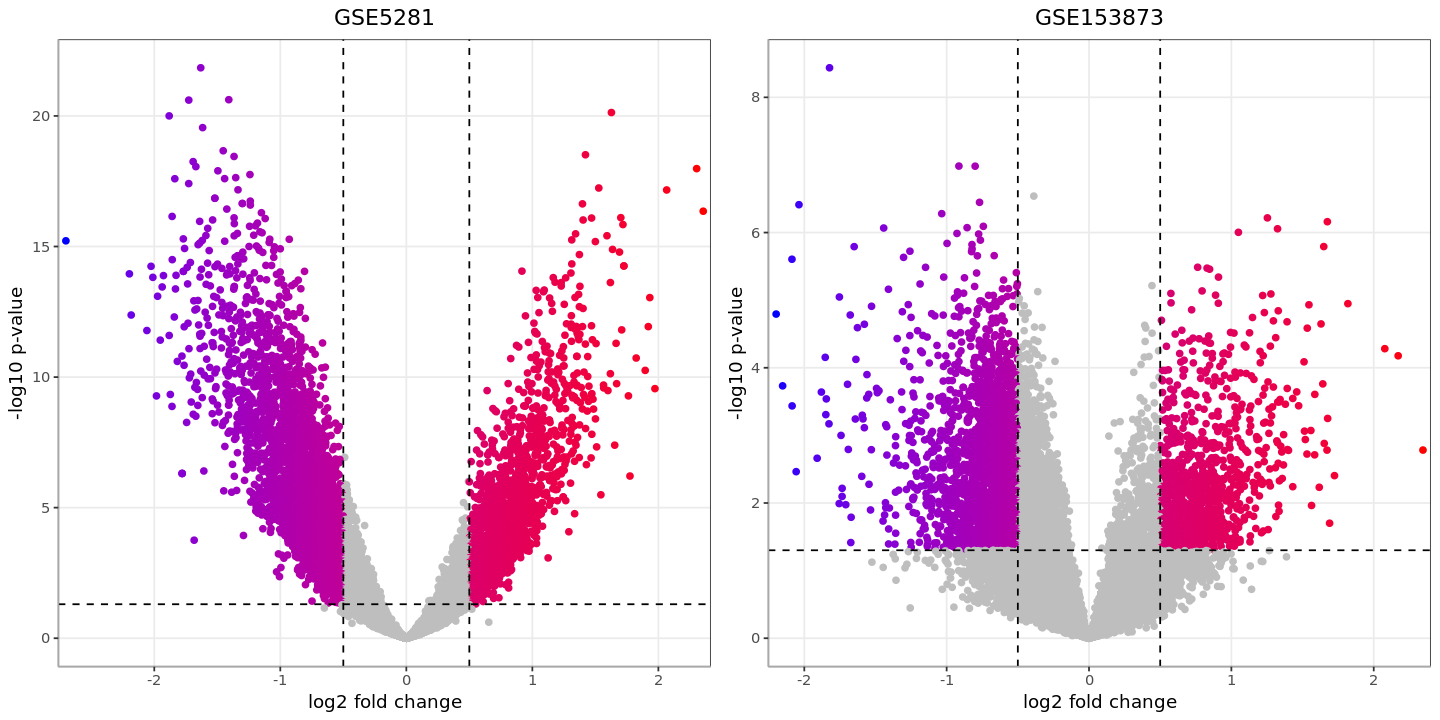

In [42]:
# Create a MA plot for the limma result of the GSE5281 dataset
Volplt1 <- plotVolcanoDE(DEResult = gse5281LimmaRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE5281")

# Create a MA plot for the limma result of the GSE153873 dataset
Volplt2 <- plotVolcanoDE(DEResult = gse153873LimmaRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedVol <- gridExtra::grid.arrange(
    Volplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    Volplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedVol

For t-test results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

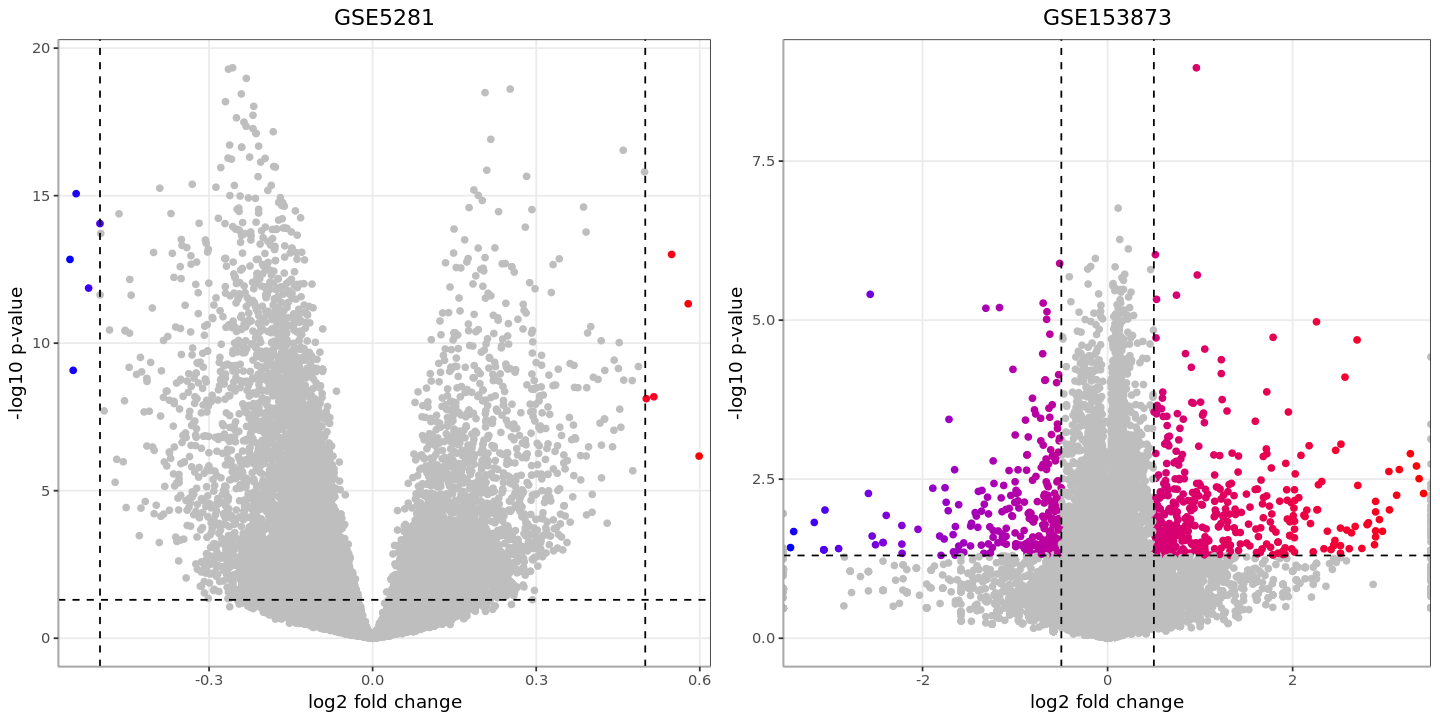

In [43]:
# Create a MA plot for the t-test result of the GSE5281 dataset
Volplt1 <- plotVolcanoDE(DEResult = gse5281TtestRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE5281")

# Create a MA plot for the t-test result of the GSE153873 dataset
Volplt2 <- plotVolcanoDE(DEResult = gse153873TtestRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedVol <- suppressWarnings(gridExtra::grid.arrange(
    Volplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    Volplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
))
combinedVol

For edgeR results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

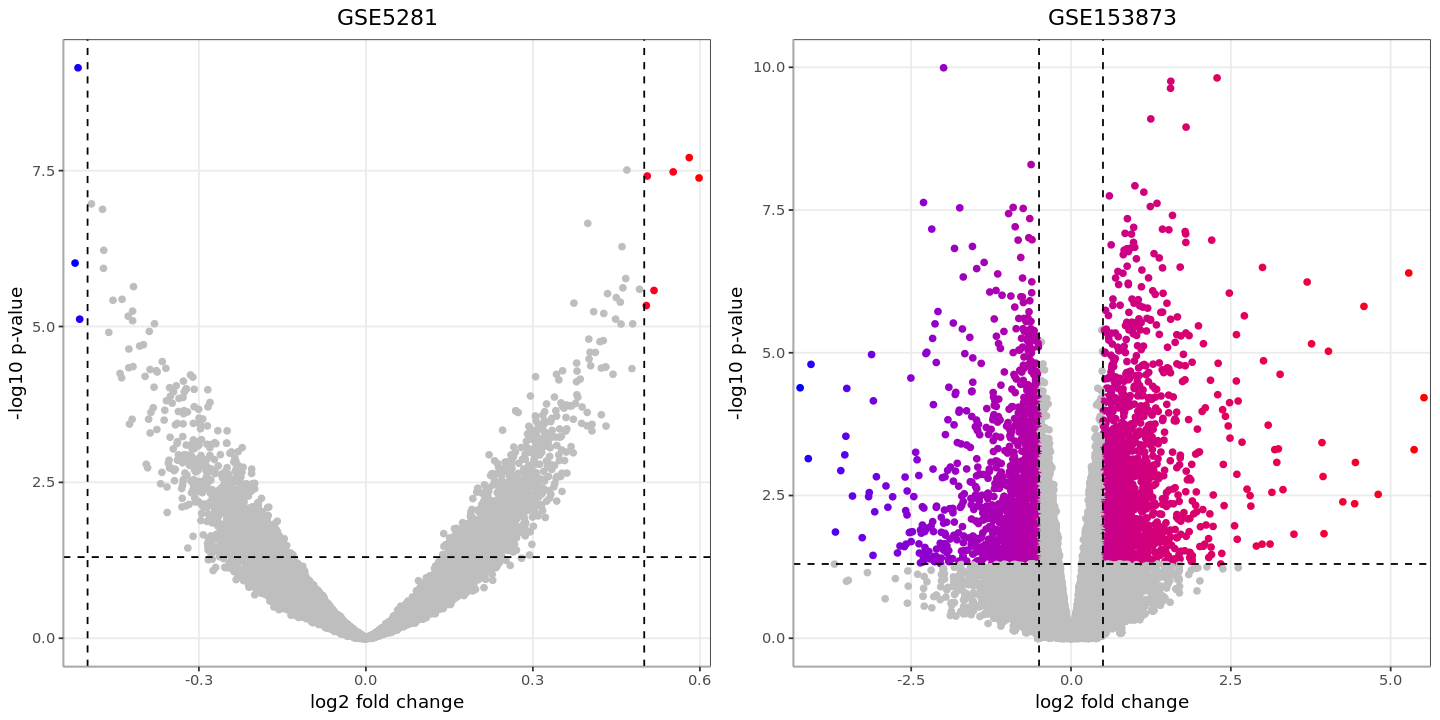

In [44]:
# Create a MA plot for the limma result of the GSE5281 dataset
Volplt1 <- plotVolcanoDE(DEResult = gse5281EdgeRRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE5281")

# Create a MA plot for the limma result of the GSE153873 dataset
Volplt2 <- plotVolcanoDE(DEResult = gse153873EdgeRRes, pThreshold = 0.05, useFDR = FALSE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedVol <- gridExtra::grid.arrange(
    Volplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    Volplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedVol

For DESeq2 results:

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

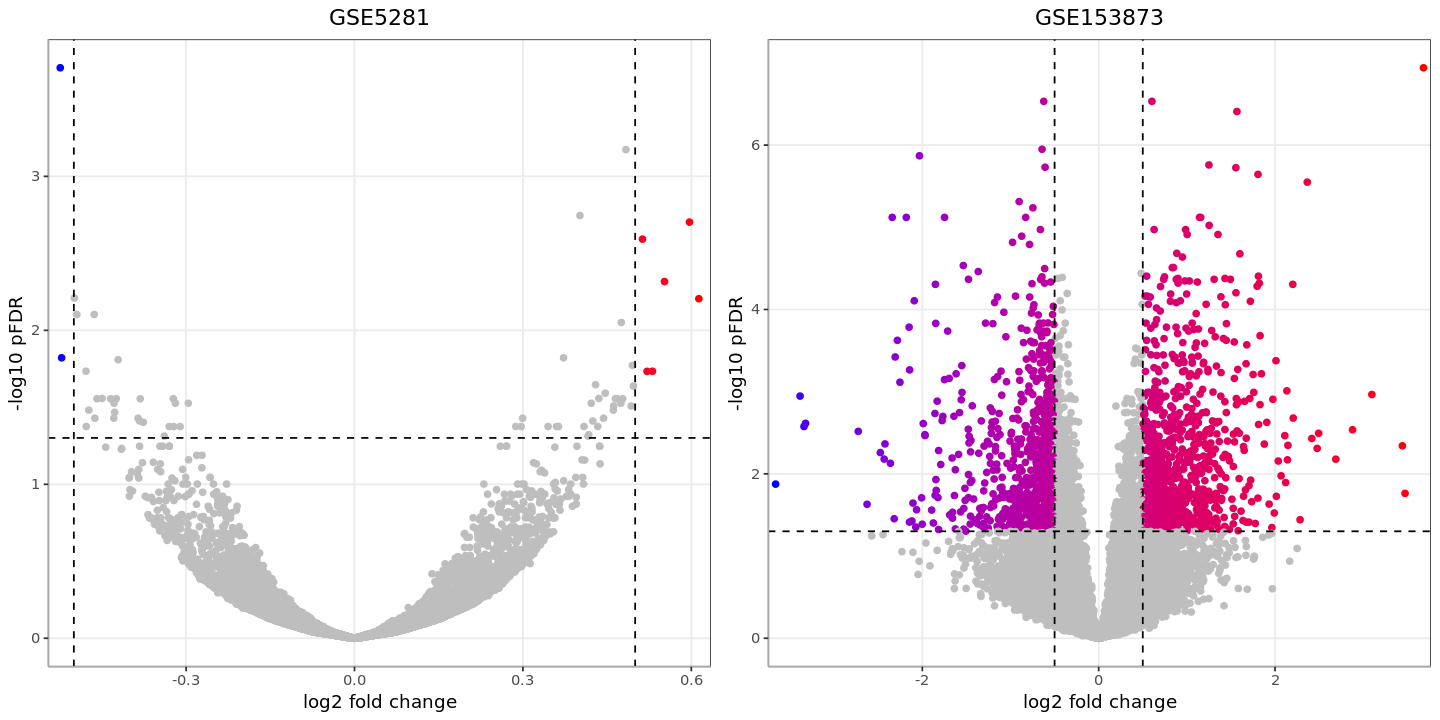

In [45]:
# Create a MA plot for the limma result of the GSE5281 dataset
Volplt1 <- plotVolcanoDE(DEResult = gse5281DESeq2Res, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE5281")

# Create a MA plot for the limma result of the GSE153873 dataset
Volplt2 <- plotVolcanoDE(DEResult = gse153873DESeq2Res, pThreshold = 0.05, useFDR = TRUE, logFCThreshold = 0.5) + ggtitle("GSE153873")

# Adjust size of the plot
options(repr.plot.width = 12, repr.plot.height = 6)
# Combine the two plots using grid.arrange function
combinedVol <- gridExtra::grid.arrange(
    Volplt1 + scale_x_continuous(expand = c(0.01, 0.01)), 
    Volplt2 + scale_x_continuous(expand = c(0.01, 0.01)),
    ncol = 2
)
combinedVol

<!-- headings -->
 <a id="visual-cc"></a>
## 3. Gene-level Consensus Analysis

To conduct a gene-level consensus analysis, we can visualize the relations between the results of different analysis methods. A Venn diagram, which uses overlapping circles or similar shapes to depict the logical relationships between two or multiple sets of items, can be utilized in this case. It will showcase the number of common DE genes among different analysis results. In addition, we can also use a heatmap to observe the differences between different differential analysis methods for a list of common DE genes. It visualizes the statistical value of each gene as a color and the magnitude of the value is depicted by the hue or the intensity of the color. 

In [46]:
# Install and import packages
suppressMessages({
    suppressWarnings(if (!require("ggvenn")) install.packages("ggvenn"))
    suppressWarnings(if (!require("ggnewscale")) install.packages("ggnewscale"))
    suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))
                     
    suppressPackageStartupMessages({library(ggvenn)})
    suppressPackageStartupMessages({library(tidyr)})
    suppressPackageStartupMessages({library(ggnewscale)})
})

<!-- headings -->
 <a id="visual-venn"></a>
 ### 3.1 Venn diagram

To generate a Venn diagram for the visualization of the differential analysis results, we can utilize the `plotVenn` below. This function requires a list of differential analysis results, each element of the list should be a result table that has the following columns: 
- (1) SYMBOL - the gene SYMBOL column;
- (2) p.value - the p-value column;
- (3) pFDR - the adjusted p-value column;
- (4) logFC - the log2 fold change column;

In [47]:
#' @ description This function generates a Venn diagram to visualize the overlap of differentially expressed genes or features
#'                 between multiple sets of results.
#'
#' @param aResults A list containing multiple sets of differential expression analysis results.
#'                 Each element in the list should be a data frame or a tibble with columns representing
#'                 differentially expressed genes or features and relevant statistics.
#' @param pThreshold A numerical value specifying the threshold for filtering differentially expressed genes (default: 0.05).
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the DE genes (default: TRUE).
#' @param stat A character string specifying the statistical metric to use for filtering genes (default: "logFC" for log-fold change).
#' @param statThreshold A numerical value specifying the threshold value for the chosen statistical metric to filter differentially expressed genes (default: 0).
#'
#' @return A Venn diagram displaying the overlap of differentially expressed genes or features among the specified result sets.

plotVenn <- function(aResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0) {
    # Check the input data requirements
    if (length(aResults) < 2) {
        stop("The number of DE results must be at least 2.")
    }

    for (Res in aResults) {
        if (useFDR && !("pFDR" %in% colnames(Res))) {
            stop("The F DR adjusted p-value column is not in the results data frame.")
        } else {
            if (!("p.value" %in% colnames(Res))) {
                stop("The p.value column is not in the results data frame.")
            }
        }

        if (!stat %in% colnames(Res)) {
            stop("The statistic column is not in the results data frame.")
        }
    }
    # Filter out DE Genes for the plot
    plotDat <- lapply(aResults, function(Res) {
            filtered_df <- filter(data.frame(Res),
                abs(.data[[stat]]) > statThreshold & (
                    if (useFDR) {
                        .data$pFDR < pThreshold
                    } else {
                        .data$p.value < pThreshold
                    }
                )
            )
            filtered_df[["SYMBOL"]]
    })
    
    if (is.null(names(plotDat))) {
        names(plotDat) <- paste0("Dataset ", seq_along(plotDat))
    }
    pR <- ggvenn::ggvenn(plotDat,
           fill_color = c(
               "#316b9d", "#f77a65",
               "#a6a1d0", "#fea9c4",
               "#74e7bc", "#febb73",
               "#1db4db", "#ffc5a6",
               "#b6c9fa", "#ee5437"),
           stroke_size = 0.5,
           set_name_size = 4,
           fill_alpha = 0.75
    ) 
    # Return the plot
    return(pR)
}


For the input of the `plotVennDE` function, we will create a list containing all the results of 4 different differential analysis methods.

In [48]:
# Put all the result dataframes to a list for the plotVennDE function
gse5281DEResults <- list(gse5281LimmaRes, gse5281TtestRes, gse5281EdgeRRes, gse5281DESeq2Res)
names(gse5281DEResults) <- c("limma", "t-test", "edgeR", "DESeq2")

# Put all the result dataframes to a list for the plotVennDE function
gse153873DEResults <- list(gse153873LimmaRes, gse153873TtestRes, gse153873EdgeRRes, gse153873DESeq2Res)
names(gse153873DEResults) <- c("limma", "t-test", "edgeR", "DESeq2")

Now we can create a venn diagram for the results of each dataset using the commands below: 

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

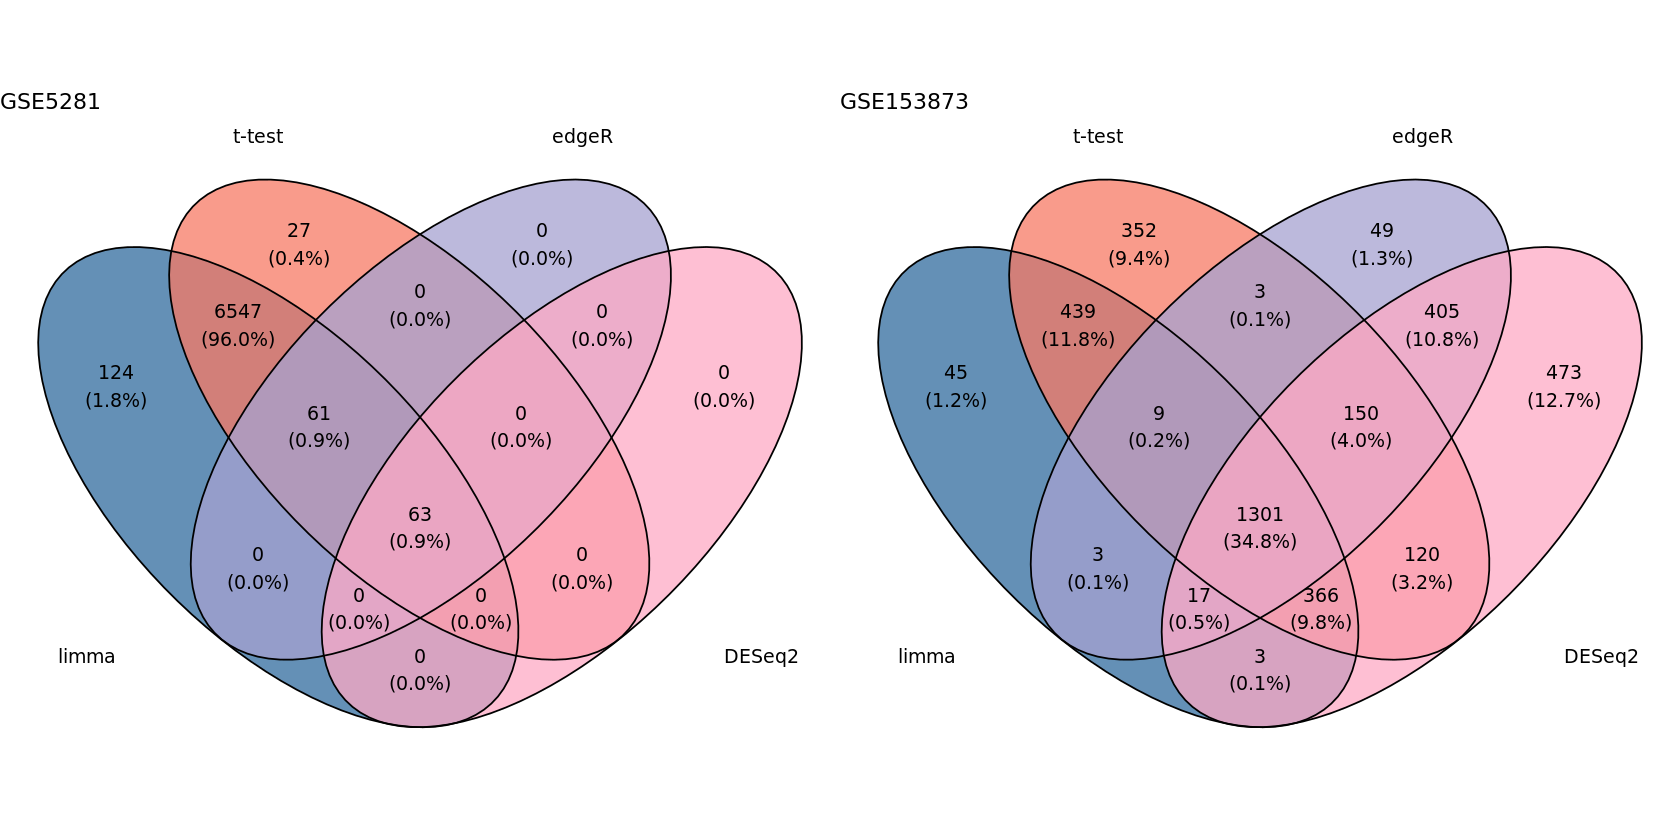

In [49]:
# Create a venn diagram for the microarray result
Vennplt1 <- plotVenn(aResults = gse5281DEResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0)
Vennplt1 <- Vennplt1 + ggtitle("GSE5281")
# Create a venn diagram for the RNA-seq result
Vennplt2 <- plotVenn(aResults = gse153873DEResults, pThreshold = 0.05, useFDR = TRUE, stat = "logFC", statThreshold = 0)
Vennplt2 <- Vennplt2 + ggtitle("GSE153873")
# Adjust size of the plot
options(repr.plot.width = 14, repr.plot.height = 7)
# Combine the two plots using grid.arrange function
combinedVenn <- gridExtra::grid.arrange(
    Vennplt1, 
    Vennplt2,
    ncol = 2
)
combinedVenn

For the microarray dataset (GSE5281), only 63 genes are identified as differentially expressed across 4 analysis methods. The limma and t-test results have and share more than 6600 DE genes while edgeR and DESeq2 found only 124 and 63 genes to be differentially expressed.

For the RNA-seq dataset (GSE153873), 1035 DE genes are shared between 4 methods. Each method identifies more than 1700 DE genes.

edgeR and DESeq2 seem to have poor performance with microarray data.

<!-- headings -->
<a id="visual-heat"></a>
### 3.2 Heatmap plot

To generate a heatmap plot for the visualization of the differential analysis results, we can utilize the `plotDEGeneHeatmap` below.  This function requires a list of differential analysis results, each element of the list should be a result table that has the following columns: 
- (1) SYMBOL - the gene SYMBOL column;
- (2) p.value - the p-value column;
- (3) pFDR - the adjusted p-value column;
- (4) logFC - the log2 fold change column;

In [50]:
#' @description Generates a heatmap for differentially expressed genes (DEGs) based on log-fold change and p-values.
#'
#' @param DEResults A list of at least length two containing DE analysis results for multiple datasets.
#' @param numGenes An integer specifying the number of common genes to plot
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the DE genes (default: TRUE).#' @param labels A named vector of labels for genes. Default is `NULL`.
#' @param logFCLims A numeric vector of length 2 specifying the limits for log-fold change. Default is c(-5, 5).
#' @param negLog10pValueLims A numeric vector of length 2 specifying the limits for negative log10 p-value. Default is c(0, 5).
#' @return A ggplot object representing the heatmap of DEGs.

plotDEGeneHeatmap <- function(DEResults, numGenes = 30, useFDR = TRUE, logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5)) {
    commonGenes <- lapply(DEResults, function(x) x$SYMBOL) 
    commonGenes <- Reduce(intersect, commonGenes)[1:numGenes]
    if (any(commonGenes == 0)) {
        stop("No common genes found between the input genes and the genes in the DE results")
    }

    DEdfs <- lapply(DEResults, function(x) x[match(commonGenes, x$SYMBOL),])

    labels <- commonGenes

    scaleMinMax <- function(x, minx, maxx) {
        x[x < minx] <- minx
        x[x > maxx] <- maxx
        x
    }

    if (is.null(names(DEdfs))) {
        names(DEdfs) <- paste0("Dataset ", seq_along(DEdfs))
    }

    plotData <- lapply(names(DEdfs), function(n) {
            DEdf <- as.data.frame(DEdfs[[n]])
            DEdf$p.value <- scaleMinMax(abs(log10(ifelse(rep(useFDR, nrow(DEdf)), DEdf$pFDR, DEdf$p.value))), negLog10pValueLims[1], negLog10pValueLims[2])
            DEdf$logFC  <-scaleMinMax(DEdf$logFC, logFCLims[1], logFCLims[2])
            DEdf$label <- factor(labels, levels = labels)
            DEdf$dataset <- n
            DEdf <- DEdf[, c("label", "logFC", "p.value", "dataset")]
            DEdf 
        
        }) 
    plotData <- do.call(plotData, what = rbind) 
    plotData <- gather(plotData, "type", "value", -"label", -"dataset") 
    plotData$label <- factor(plotData$label, levels = labels)
    plotData$dataset <- factor(plotData$dataset, levels = names(DEdfs))
    plotData$type <- factor(plotData$type, levels = c("p.value", "logFC"))
    plotData$colOrder <- as.numeric(plotData$dataset) + as.numeric(plotData$type)*length(DEdfs) + as.numeric(plotData$dataset)*0.01 + as.numeric(plotData$type)*0.1

    uniqueY <- sort(unique(plotData$colOrder))

    x <- ggplot() +
        geom_tile(data = plotData[plotData$type == "logFC",], aes(x = .data$label, y = .data$colOrder, fill = .data$value, width = 1, height = 1)) +
        scale_fill_gradient2(
            high = "#B80F0A",
            low = "#004F98",
            mid = "white",
            na.value = "white",
            limits = logFCLims,
        ) +
        labs(fill = "log2 FC") +
                    
        new_scale_fill() +
        geom_tile(data = plotData[plotData$type == "p.value",], aes(x = .data$label, y = .data$colOrder, fill = .data$value, width = 1, height = 1)) +
        scale_fill_gradient(
            low = "white",
            high = "#B80F0A",
            na.value = "white",
            limits = negLog10pValueLims,
            guide = guide_colorbar(title = paste0("-log10", ifelse(useFDR, " pFDR", " p-value")))
        ) +
        theme_minimal() +
        coord_flip() +
        theme(
            axis.title.y = element_blank(),
            axis.title.x = element_blank(),
            axis.text.x.bottom = element_text(angle = 45, vjust = 1, hjust = 1),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
        ) +
        scale_x_discrete(
            labels = labels
        ) +
        scale_y_continuous(
            breaks = uniqueY,
            labels = rep(names(DEdfs), 2),
            expand = c(0, 0),
            sec.axis = sec_axis(~., breaks = sapply(seq_along(c(
              paste0("-log10", ifelse(useFDR, " pFDR", " p-value")),
              "log2 FC"
            )), function(i) mean(uniqueY[(i-1)*length(DEdfs) + 1:length(DEdfs)])), labels = c(
              paste0("-log10", ifelse(useFDR, " pFDR", " p-value")),
              "log2 FC"
            ))
        )
                                
    return(x)
}

We will create a heat map for 30 genes common genes among 4 different DE analysis methods for the results of each dataset.  We can use the inputs prepared for the venn diagrams with the following codes.

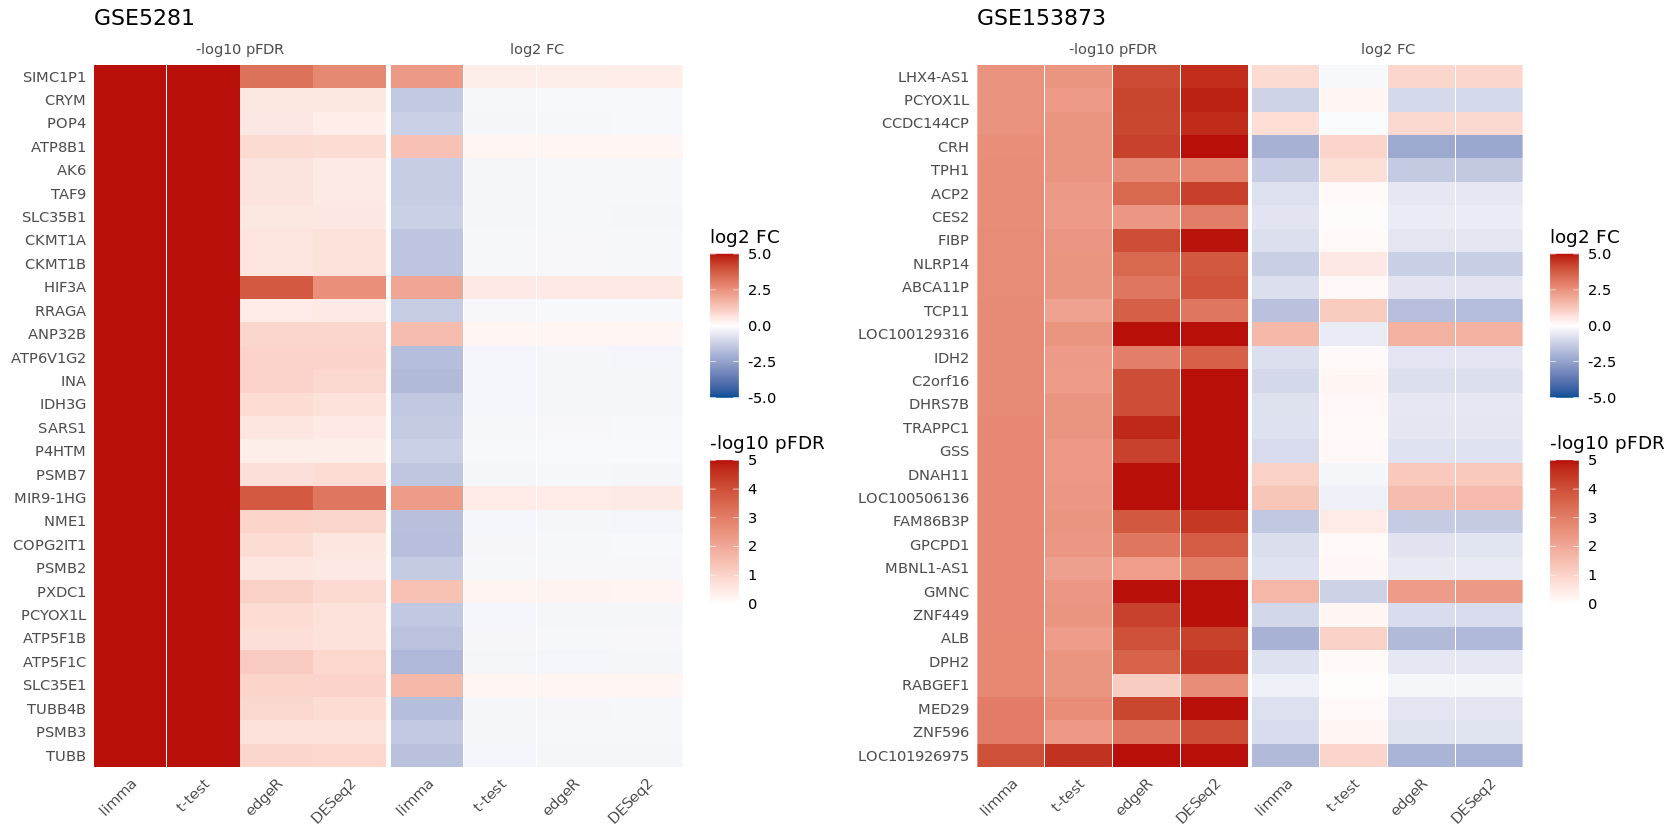

In [51]:
# Create a heat map for DE analysis results
heatmap1 <- plotDEGeneHeatmap(gse5281DEResults, numGenes = 30, useFDR = TRUE,  logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5))
heatmap1 <- heatmap1 + ggtitle("GSE5281")
# Create a heat map for DE analysis results
heatmap2 <- plotDEGeneHeatmap(gse153873DEResults, numGenes = 30, useFDR = TRUE,  logFCLims = c(-5, 5), negLog10pValueLims = c(0, 5))
heatmap2 <- heatmap2 + ggtitle("GSE153873")
# Adjust size of the plot
options(repr.plot.width = 14, repr.plot.height = 7)
# Combine the two plots using grid.arrange function
combinedPlt1 <- gridExtra::grid.arrange(
    heatmap1, 
    heatmap2,
    ncol = 2
)

From the above heatmaps, we can see that the common genes of limma and t-test result have similar p-value FDR for the microarray dataset (GSE5281) while those of the edgeR and DESeq2 results have similar p-value FDR for the RNA-seq dataset (GSE153873).

The next submodule will show how to identify the pathways that these genes are involved in. 


In [52]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.13.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggnewscale_0.4.10           ggvenn_0.1.10              
 [3] dplyr_1.1.4                 tidyr_1.3.1                
 [5] DESeq2_1.42.0               SummarizedExperiment_1.32.0
 [7] Bioba